# Evaluation of the Na2BaMn(PO4)2 measurement

In [1]:
#imports

# this will import numpy, scipy, matplotlib + ufit
from ufit.lab import *

import sys
import os
import re
import math
from string import ascii_lowercase
from itertools import product
from subprocess import run

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cbook import flatten
from matplotlib.ticker import FormatStrFormatter   # or FuncFormatter
from matplotlib.lines import Line2D
from matplotlib.patches import Circle

from scipy.signal import find_peaks
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import griddata

from PIL import Image

from periodictable import formula

# Enable inline plotting in Jupyter Notebook
%matplotlib inline
# style for PRB
plt.style.use('physrev.mplstyle') # Set full path to if physrev.mplstyle is not in the same in directory as the notebook
plt.rcParams['figure.dpi'] = "300"

In [2]:
# helper functions

#parsing string to range
def getList(nstring):

    def toint(a):
        try:
            return int(a)
        except ValueError:
            raise Exception('Invalid file number: %r' % a) from None
        
    nstring = nstring.replace('+',',').replace('>','-')
    parts1 = nstring.split(',')

    datasets = []
    for part1 in parts1:
        if '-' in part1:
            a, b = map(toint, part1.split('-'))
            datasets.extend(range(a, b+1))
        else:
            datasets.append(toint(part1))
    return datasets

# mapping functions
def get_xss_yss_zss(x, y, runs, log=False):
    # XXX duplication
    xss = np.array(list(flatten(run[x] for run in runs)))
    yss = np.array(list(flatten(run[y] for run in runs)))
    if log:
        zss = list(flatten(np.log10(run["cts"]) for run in runs))
    else:
        zss = list(flatten(run["cts"] for run in runs))
    return xss, yss, zss

def bin_mapping(x, y, runs, log=False, xscale=1, yscale=1,
                interpolate=100, minmax=None):
    from scipy.interpolate import griddata
    xss, yss, zss = get_xss_yss_zss(x, y, runs, log)
    xss *= xscale
    yss *= yscale
    if minmax is not None:
        if log:
            minmax = list(map(np.log10, minmax))
        zss = np.clip(zss, minmax[0], minmax[1])
    interpolate = interpolate * 1j
    xi, yi = np.mgrid[min(xss):max(xss):interpolate,
                      min(yss):max(yss):interpolate]
    zi = griddata(np.array((xss, yss)).T, zss, (xi, yi))
    return xss/xscale, yss/yscale, xi/xscale, yi/yscale, zi

# Whenever UnivariateSpline is called it print "returning". To negate this the blocPrint disables all print and enablePrint functions allows the user to print 
def blockPrint():
    global old_stdout
    old_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')

def enablePrint():  #restore
    sys.stdout = old_stdout

# plotting of the model data
def column_to_plot(folder, toprint=False):
    import math

    vampire_input = folder + '/input'

    if toprint: print('Input file:', vampire_input)

    # read vampire input and return all lines with "output:"
    outputs = []
    mat_file = None
    with open(vampire_input, 'r') as f:
        for line in f:
            if "output:" in line and line[0] != "#":
                outputs.append(line.split(':')[1])

            if "material:file" in line and line[0] != "#":
                mat_file = line.split('=')[1].replace('\n','')
                mat_file = vampire_input.split('/input')[0] + '/' + mat_file
                if toprint: print('Material file:', mat_file)

    if mat_file:
        with open(mat_file, 'r') as f:
            for line in f:
                if "material:num-materials" in line and line[0] != "#":
                    num_spins = int(line.split('=')[1])
                    if toprint: print('Number of spins:', num_spins, ', read from material file.')

    num_column_outputs = {
        "real-time":                   {"quantity size":1, "n_spin":1},
        "temperature":                 {"quantity size":1, "n_spin":1},
        "applied-field-strength":      {"quantity size":1, "n_spin":1},
        "material-mean-magnetisation": {"quantity size":4, "n_spin":num_spins},
        "material-mean-susceptibility":{"quantity size":4, "n_spin":num_spins},
        "material-mean-specific-heat": {"quantity size":1, "n_spin":num_spins},
        "mean-magnetisation":          {"quantity size":4, "n_spin":1},
        "mean-susceptibility":         {"quantity size":4, "n_spin":1},
        "mean-specific-heat":          {"quantity size":1, "n_spin":1},
    }

    num_output = 0
    list_of_output = {}
    # outputs_to_plot = []
    start_column = 0
    final_column = 0

    for i, output in enumerate(outputs):
        output_aux = output.replace('\n','')
        output_aux = output_aux.replace(' ','')

        quantity_size = num_column_outputs[output_aux]["quantity size"]
        n_spin =  num_column_outputs[output_aux]["n_spin"]
        start_column = final_column
        final_column = start_column + quantity_size*n_spin

        if "real-time" not in output and "temperature" not in output and "applied-field-strength" not in output:
            num_output+=1
            # outputs_to_plot.append({'output':output_aux, 'start_column':start_column, 'final_column':final_column, 'quantity size':quantity_size, 'n_spin':n_spin })
            list_of_output[output_aux] = { 'start_column':start_column, 'final_column':final_column, 'quantity size':quantity_size, 'n_spin':n_spin }
            
            if toprint: print('Output:', output_aux, 'columns:', start_column, '-', final_column)

        if "temperature" in output:
            first_column = start_column
            if toprint: print("Reading temperature in column:", first_column)
            label_xaxis = 'Temperature (K)'
        if "applied-field-strength" in output:
            first_column = start_column
            if toprint: print("Reading applied-field-strength in column:", first_column)
            label_xaxis = 'Applied field (T)'

    return list_of_output

def phase_diagram_colormap(folder, color='gray', property=36, ax=None, fig=None, title=None, 
                           xlab = "", ylab = "", bar = True, **args):
    import os
    files = [f for f in os.listdir(folder) if f.startswith("output_") ]
    files.sort()

    if ax is None:
        fig, ax = plt.subplots()

    if property == 'susceptibility':
        cols = [36]
    elif property == 'specific_heat':
        cols = [37]
    else : cols = property

    if type(cols) == int:
        cols = [cols]

    if 'plot_derivative' in args: 
        plot_derivative = args['plot_derivative']
    else :
        plot_derivative = False

    if 'xlim' in args: 
        xlim = args['xlim']
    else :
        xlim = False

    if 'cmap' in args: 
        cmap = args['cmap']
    else :
        cmap = 'viridis'

    if 'shading' in args: 
        shading = args['shading']
    else :
        shading = 'gouraud'

    Ts = []
    zs = np.array([])
    for file in files:
        # if file == files[0]: continue # if to skip the first temperature
        temperature = float(file.split('_')[1])
        Ts.append(temperature)
        z_sum=0
        for column in cols:
            Bs, z = np.loadtxt(folder + '/' + file, usecols=(1,column)).T
            z_sum += z

        # find index of element 8 in Bs
        idx = np.where(Bs == max(Bs))[0][0]
        # remove element idx from Bs
        Bs = np.delete(Bs, idx)
        z_sum = np.delete(z_sum, idx)
        
        if plot_derivative:
            z_sum = np.gradient(z_sum, Bs)
        
        zs = np.append(zs, z_sum)

    num_T = len(Ts)
    num_B = len(Bs)

    X, Y = np.meshgrid(Ts, Bs)
    Z = zs.reshape(num_T, num_B).T
    if plot_derivative:
        Z = Z
    else:
        Z = np.log(Z)

    cmap = plt.get_cmap(cmap)
    data = ax.pcolormesh(X, Y, Z, cmap=cmap, shading=shading)
    if bar:
        fig.colorbar(data, ax=ax)

    if plot_derivative:
        data.set_clim(-50, 50)
    else: 
        data.set_clim(0, np.max(Z))

    if xlim: 
        ax.set_xlim(xlim)
    else:
        ax.set_xlim(0.05, np.max(Ts))

    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    if title is not None:
        ax.set_title(title)
    return data

def plot_phase_diagram(folder, ax, fig, property, title, list_of_output, quantity_column_selection=5, **args):
    dict_of_output = list_of_output[property]
    # print('dict_of_output:', dict_of_output)

    output = property
    start_column = dict_of_output['start_column']
    final_column = dict_of_output['final_column']
    quantity_size = dict_of_output['quantity size']
    n_spin = dict_of_output['n_spin']

    # which column? mx, my, mz, |m|
    quantity_column = min(quantity_column_selection, quantity_size)
    # quantity_column = quantity_size
    # print('quantity_column:', quantity_column, quantity_column_selection, quantity_size)
    
    ys = np.zeros(0)
    list_columns = []
    for i in range(n_spin):
        list_columns.append( start_column-1 + i*quantity_size + quantity_column )

    if quantity_column_selection == 5: list_columns = list(range(start_column, final_column))
    # print('property:', property, ', columns:', list_columns); print()
    return phase_diagram_colormap(folder, color='tab:blue'  ,ax=ax, fig=fig, property = list_columns, title=title, **args)

def phase_diagram_colormap_plotall(folder, quantity_column_selection=5, **args):
    fig, axes = plt.subplots(1,4, figsize=(25,4))

    if 'toprint' in args: 
        toprint = args['toprint']
    else :
        toprint = False

    if 'fig_title' in args: 
        fig_title = args['fig_title']
    else :
        fig_title = None

    list_of_output = column_to_plot(folder, toprint=toprint)

    plot_phase_diagram(folder, axes[0], fig, property='mean-susceptibility',          title='Susceptibility',          list_of_output=list_of_output, quantity_column_selection=quantity_column_selection, **args)
    plot_phase_diagram(folder, axes[1], fig, property='material-mean-susceptibility', title='Susceptibility per spin', list_of_output=list_of_output, quantity_column_selection=quantity_column_selection, **args)
    plot_phase_diagram(folder, axes[2], fig, property='mean-specific-heat',           title='Specific Heat',           list_of_output=list_of_output, quantity_column_selection=quantity_column_selection, **args)
    plot_phase_diagram(folder, axes[3], fig, property='material-mean-specific-heat',  title='Specific heat per spin',  list_of_output=list_of_output, quantity_column_selection=quantity_column_selection, **args)

    # add a title to the figure
    if fig_title : fig.suptitle(fig_title, fontsize=16)


## Neutron measurement on D23

In [3]:
# define ranges/lists of data which are needed
r_c_300 =  "92910-92929"
r_c_600 =  "92933,92939,92944,92952"
r_c_1200 =  "92981-92997"
r_ab_300 = "90056-090086"
r_ab_600 = "106065,106072,106074,106080,106087"
r_ab_1200 = "90117-90135"

In [4]:
# data download from the trusted source
# by default it is skipped, because these data are included in this repository

if False:
    from illdata import IllSftp
    sftp = IllSftp(
        hostname="dt.ill.fr",
        username="",
        password="" # do not push to any repo ;)
        #alternative way of obtaining password everytime (you need import getpass)
        # password = getpass.getpass("Enter password for data.ill.fr: ")
    )

    # Connect to SFTP
    sftp.connect()
    # get raw nxs and ill data + processed dat files
    def getNumor(numor):
        # Syntax:         remote folder          local folder
        sftp.download(f"rawdata/{numor:06d}", f"./rawdata/{numor:06d}")
        sftp.download(f"rawdata/{numor:06d}.nxs", f"./rawdata/{numor:06d}.nxs")
        sftp.download(f"processed/numors/{numor:06d}.dat", f"./rawdata/{numor:06d}.dat")


    # H_c
    sftp.openproposal("CRG-3064_241_d23")
    for numor in getList(r_c_300) + getList(r_c_600) + getList(r_c_1200):  
        getNumor(numor)
        
    sftp.openproposal("CRG-3064_242_d23")
    for numor in getList(r_ab_600):  
        getNumor(numor)

    sftp.openproposal("5-41-1252_241_d23")
    for numor in getList(r_ab_300) + getList(r_ab_1200):  
        getNumor(numor)
    sftp.disconnect()

In [5]:
# set a template, so that data can be referenced by number only
set_datatemplate('./rawdata/%06d.dat')

# empty dataframes
dfs = { "c_300": { "d": [],
                 "ranges": r_c_300},
        "c_600": { "d": [],
                 "ranges": r_c_600},
        "c_1200": { "d": [],
                 "ranges": r_c_1200},
        "ab_300": { "d": [],
                 "ranges": r_ab_300},
        "ab_600": { "d": [],
                 "ranges": r_ab_600},
        "ab_1200": { "d": [],
                 "ranges": r_ab_1200},
}

# read the data 
for k,v in dfs.items():
    # Read the data file into a DataFrame
    for n in getList(v["ranges"]) :
        df = pd.read_csv(f'./rawdata/{n:06d}.dat', sep='\\s+', header=None, 
                        names=['H', 'K', 'L', 'cts', 'mon1', 'mon2', '2theta', 'omega', 'chi', 'ts', 'treg', 'b'])
        v["d"].append(df)

In [6]:
# SHOW ALL plots
if False:
    for k in dfs.keys():
        # Use bin_mapping to interpolate data
        xss, yss, xi, yi, zi = bin_mapping("L", "b", dfs[k]["d"], interpolate=100)

        # Create the plot with imshow
        fig, ax = plt.subplots()
        im = ax.imshow(zi.T, origin='lower', aspect='auto',
                    interpolation='nearest',
                    vmin=zi.min(),
                    vmax=zi.max(),
                    extent=(xi.min(), xi.max(), yi.min(), yi.max()))
        ax.set_xlabel('$\\mathbf{Q}=(1/3,1/3,Q_{l})$ (r.l.u.)')
        ax.set_ylabel('$B$ (T)')
        ax.set_title( k)
        fig.colorbar(im, ax=ax, label='Intensity (arb.u.)')
        plt.show()

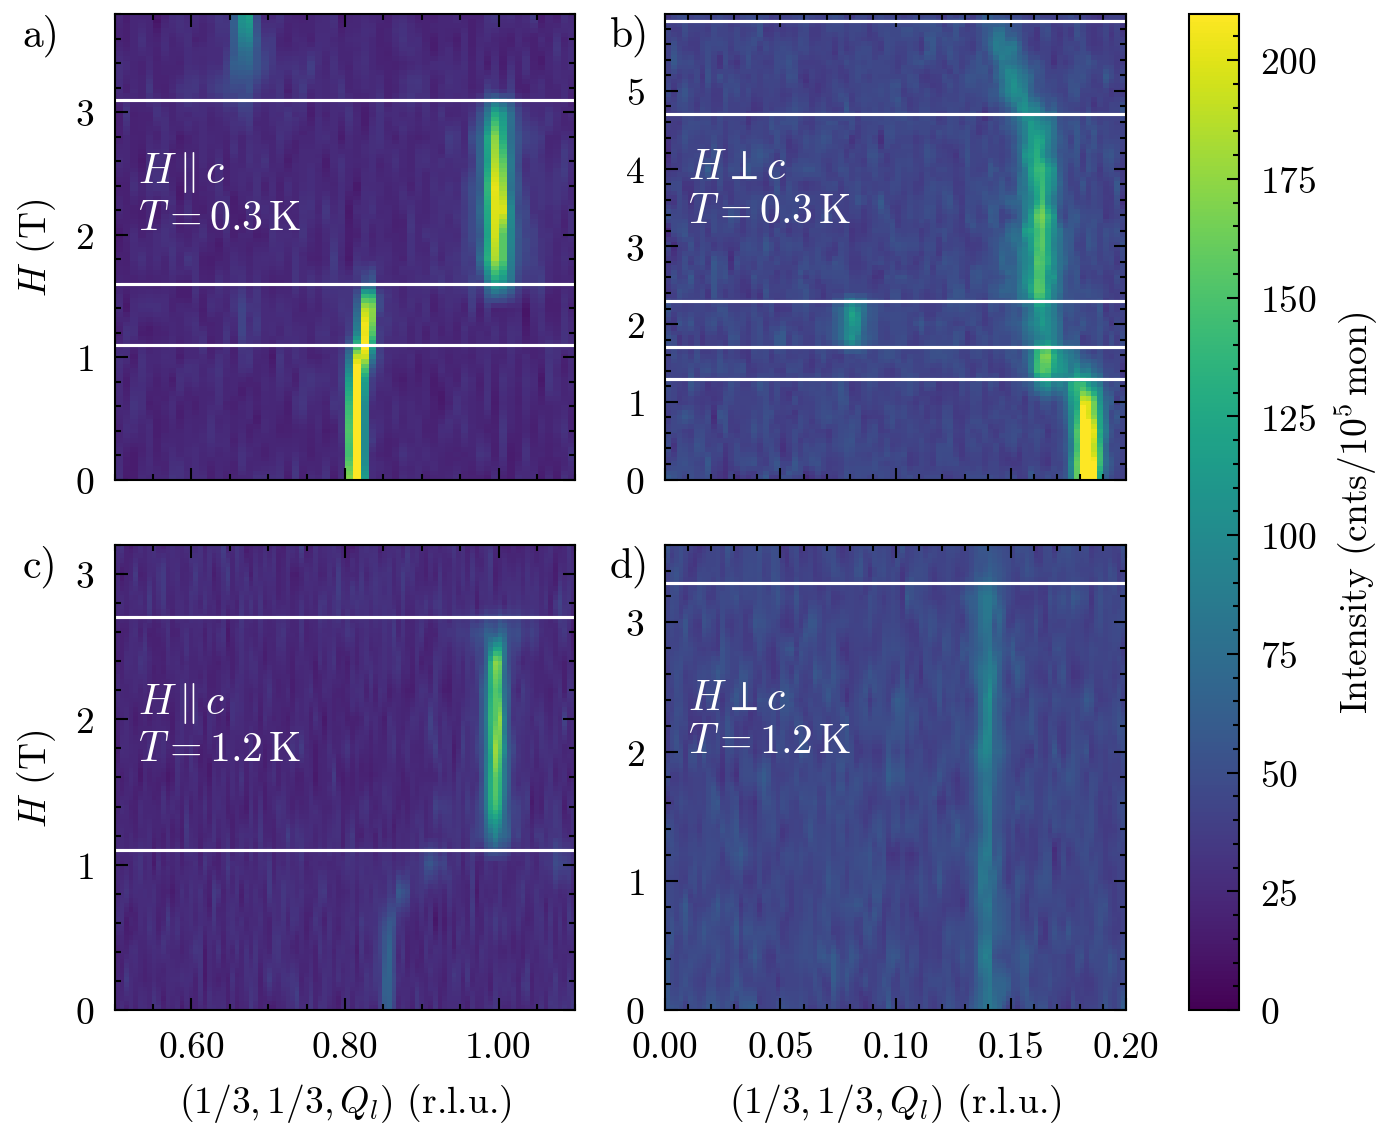

In [7]:
# Desired order: top row “c_…”, bottom row “ab_…”
keys = ["c_300", "ab_300", "c_1200", "ab_1200"]

# load phase boundaries
dfb = pd.read_csv(f'./boundaries.dat', sep=',')

# 1) Pre-compute everything and find a global color-scale range
results = {}
z_min, z_max = np.inf, -np.inf

for k in keys:
    # Interpolate data onto a grid
    xss, yss, xi, yi, zi = bin_mapping("L", "b", dfs[k]["d"], interpolate=100)
    results[k] = (xi, yi, zi)
    z_min = min(z_min, zi.min())
    z_max = max(z_max, zi.max())

# Manually adjust z_max
z_min = 0
z_max = 0.6 * z_max
# 2) Create a 2×2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(5, 4), sharex="col")

letters = [f"{ch})" for ch in ascii_lowercase[:4]]  # ['a)', 'b)', 'c)', 'd)']

for idx, (k, tag) in enumerate(zip(keys, letters)):
    ax = axes[idx // 2, idx % 2]          # row = idx//2, column = idx%2
    xi, yi, zi = results[k]

    xmax = xi.max()
    if idx == 1:
        xmax = 0.2
    elif idx == 0:
        xmax = 1.1

    im = ax.imshow(
        zi.T,
        origin="lower",
        aspect="auto",
        interpolation="nearest",
        vmin=z_min,
        vmax=z_max,
        extent=(xi.min(),  xi.max(), yi.min(), yi.max())
    )
    ax.set_xlim(xi.min(), xmax)

    if idx == 1:
        ax.set_ylim(0, 5.99)

    #
    #  Titles and axis labels
    # ax.set_title(k)
    if idx % 2 == 0:                      # left column → show y-axis label
        ax.set_ylabel("$H$ (T)")
        bdir = "\\,\\|\\,"
        bdir2 = "c"
    else:
        bdir = "\\perp"
        bdir2 = "ab"
    if idx // 2 == 1:                     # bottom row → show x-axis label
        # ax.set_xlabel("$\\mathbf{Q} = (1/3, 1/3, Q_{l})$ (r.l.u.)")
        ax.set_xlabel("$(1/3, 1/3, Q_{l})$ (r.l.u.)")
        
        temp = "1.2"
    else:
        temp = "0.3"
    ax.text(
        0.05, 0.71, f"$H {bdir} c$\n$T = {temp}\\,\\mathrm{{K}}$",
        transform=ax.transAxes,
        fontsize="medium",
        fontweight="bold", color="white",
        va="top", ha="left"
    )
    ax.text(
        -0.2 + (0.08 if idx % 2 != 0 else 0), 1, f"{tag}",
        transform=ax.transAxes,
        fontsize="medium",
        fontweight="bold",
        va="top", ha="left"
    )
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # add phase boundaries
    for y in dfb[(dfb["dir"] == bdir2) & (dfb["T(K)"] == float(temp))]["H(T)"]:
        ax.axhline(y=y, color='white')  # Adds the lines

fig.tight_layout()
# 3) One shared colorbar on the right
cbar = fig.colorbar(
    im, ax=axes.ravel().tolist(),
    location="right", label=r"Intensity (cnts/10$^{5}\,$mon)",
    shrink=1.0
)
plt.savefig("fig2.pdf")
plt.show()



Fitting B=0.00T with c_600, resulting peaks:
0.8125+-0.0002, 
Fitting B=1.20T with c_600, resulting peaks:
0.8307+-0.0003, 
Fitting B=2.20T with c_600, resulting peaks:
0.9972+-0.0002, 
Fitting B=3.80T with c_600, resulting peaks:
0.6660+-0.0003, 
Fitting B=0.00T with ab_600, resulting peaks:
-0.1877+-0.0001, 
Fitting B=1.40T with ab_600, resulting peaks:
-0.1814+-0.0002, 0.1670+-0.0002, 0.3325+-0.0007, 
Fitting B=1.80T with ab_600, resulting peaks:
-0.0835+-0.0001, 0.1673+-0.0003, 0.3334+-0.0002, 
Fitting B=3.00T with ab_600, resulting peaks:
0.1655+-0.0001, 0.3316+-0.0006, 
Fitting B=4.40T with ab_600, resulting peaks:
-0.1535+-0.0002, 


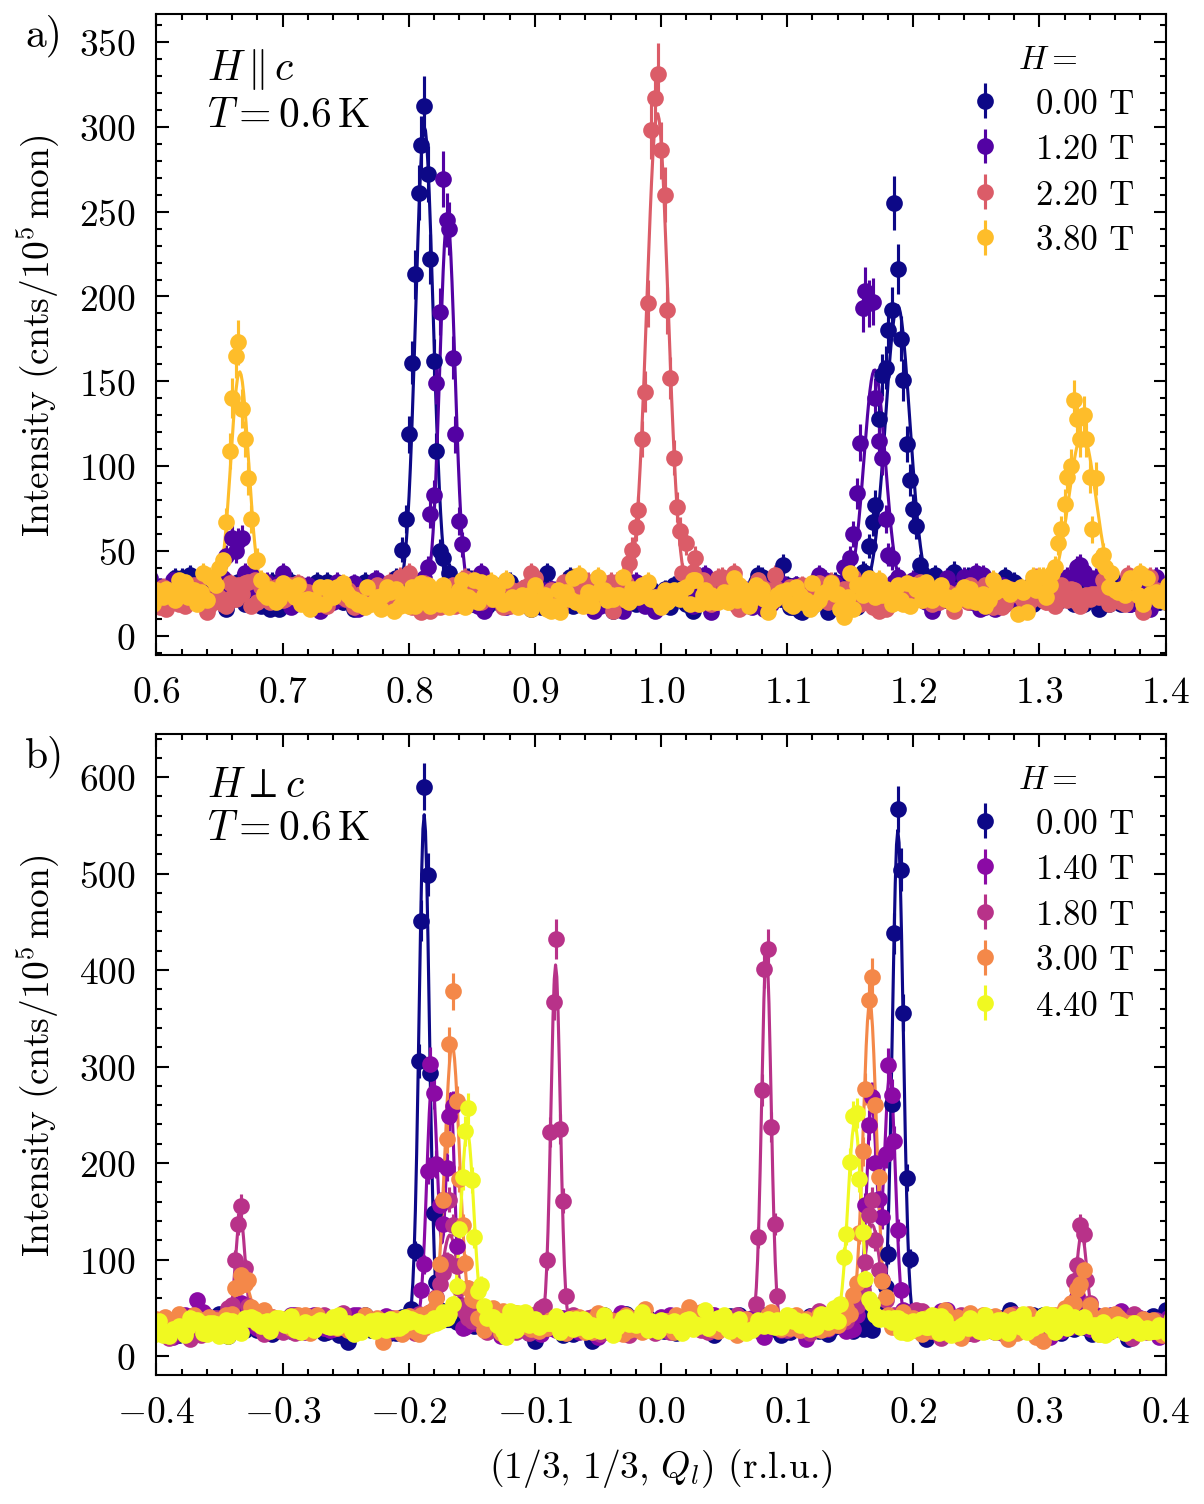

In [8]:
# What we want to show: top = c_600, bottom = ab_600
keys = ["c_600", "ab_600"]

# ------------------------------------------------------------------
# 1) Collect every distinct field value across *all* scans
# ------------------------------------------------------------------
all_fields = []
for key in keys:
    for df_scan in dfs[key]["d"]:            # dfs[key]["d"] is a list of DF
        # Assume field value is constant inside one scan → take the first row
        all_fields.append(df_scan["b"].iloc[0])

all_fields = np.unique(all_fields)
all_fields.sort()
# Consistent colours for the same B in both panels
cmap = matplotlib.colormaps["plasma"]
colours = {
    H: cmap(i / (len(all_fields) - 1))
    for i, H in enumerate(all_fields)
}

# ------------------------------------------------------------------
# 2) Build a two-row figure, share x-axis
# ------------------------------------------------------------------
fig, axes = plt.subplots(
    2, 1, figsize=(4, 5), constrained_layout=True
)

# ------------------------------------------------------------------
# 3) Plot every scan (one DataFrame = one line)
# ------------------------------------------------------------------
for ax, key in zip(axes, keys):

    for df_scan in dfs[key]["d"]:
        H = df_scan["b"].iloc[0]                 # field for this scan

        # do ufit fitting
        d = as_data(df_scan["L"], df_scan["cts"], sqrt(df_scan["cts"]))
        x_max = d.x[np.argmax(d.y)]
        # only one peak
        if abs(x_max - 1) < 0.05:
            m = Background() + \
                Gauss('apeak', pos=x_max, ampl=200, fwhm=0.02)
        else:
            # fix peaks asymetric
            fix_symmetry = True
            if fix_symmetry:
                if x_max > 0.5: # around 1
                    m = Background() + \
                        Gauss('apeak1', pos=x_max, ampl=200, fwhm=0.02) + \
                        Gauss('bpeak1', pos="2 - apeak1_pos", ampl=200, fwhm=0.02)
                else:
                    if H > 1.0 and H < 1.5: # 6 peaks
                        x_p2 = 0.165
                        x_p3 = 0.333
                        m = Background() + \
                            Gauss('apeak1', pos=x_max, ampl=200, fwhm=0.02) + \
                            Gauss('bpeak1', pos="- apeak1_pos", ampl=200, fwhm=0.02) + \
                            Gauss('apeak2', pos=x_p2, ampl=200, fwhm=0.02) + \
                            Gauss('bpeak2', pos="- apeak2_pos", ampl=200, fwhm=0.02) + \
                            Gauss('apeak3', pos=x_p3, ampl=200, fwhm=0.02) + \
                            Gauss('bpeak3', pos="- apeak3_pos", ampl=200, fwhm=0.02)
                    elif H > 1.5 and H < 2: # 6 peaks
                        x_p2 = 0.165
                        x_p3 = 0.333
                        m = Background() + \
                            Gauss('apeak1', pos=x_max, ampl=200, fwhm=0.02) + \
                            Gauss('bpeak1', pos="- apeak1_pos", ampl=200, fwhm=0.02) + \
                            Gauss('apeak2', pos=x_p2, ampl=200, fwhm=0.02) + \
                            Gauss('bpeak2', pos="- apeak2_pos", ampl=200, fwhm=0.02) + \
                            Gauss('apeak3', pos=x_p3, ampl=200, fwhm=0.02) + \
                            Gauss('bpeak3', pos="- apeak3_pos", ampl=200, fwhm=0.02)
                    elif H > 2 and H < 3.5: # 4 peaks
                        x_p2 = 0.333
                        m = Background() + \
                            Gauss('apeak1', pos=x_max, ampl=200, fwhm=0.02) + \
                            Gauss('bpeak1', pos="- apeak1_pos", ampl=200, fwhm=0.02) + \
                            Gauss('apeak2', pos=x_p2, ampl=200, fwhm=0.02) + \
                            Gauss('bpeak2', pos="- apeak2_pos", ampl=200, fwhm=0.02)
                    else:
                        m = Background() + \
                            Gauss('apeak1', pos=x_max, ampl=200, fwhm=0.02) + \
                            Gauss('bpeak1', pos="- apeak1_pos", ampl=200, fwhm=0.02)
            else:
                if x_max > 0.5: # around 1
                    m = Background() + \
                        Gauss('apeak1', pos=x_max, ampl=200, fwhm=0.02) + \
                        Gauss('bpeak1', pos=2 - x_max, ampl=200, fwhm=0.02)
                else:
                    if H > 1.0 and H < 1.5: # 6 peaks
                        x_p2 = 0.165
                        x_p3 = 0.333
                        m = Background() + \
                            Gauss('apeak1', pos=x_max, ampl=200, fwhm=0.02) + \
                            Gauss('bpeak1', pos=-x_max, ampl=200, fwhm=0.02) + \
                            Gauss('apeak2', pos=x_p2, ampl=200, fwhm=0.02) + \
                            Gauss('bpeak2', pos=-x_p2, ampl=200, fwhm=0.02) + \
                            Gauss('apeak3', pos=x_p3, ampl=200, fwhm=0.02) + \
                            Gauss('bpeak3', pos=-x_p3, ampl=200, fwhm=0.02)
                    elif H > 1.5 and H < 3.5: # 4 peaks
                        x_p2 = 0.333
                        m = Background() + \
                            Gauss('apeak1', pos=x_max, ampl=200, fwhm=0.02) + \
                            Gauss('bpeak1', pos=-x_max, ampl=200, fwhm=0.02) + \
                            Gauss('apeak2', pos=x_p2, ampl=200, fwhm=0.02) + \
                            Gauss('bpeak2', pos=-x_p2, ampl=200, fwhm=0.02)
                    else:
                        m = Background() + \
                            Gauss('apeak1', pos=x_max, ampl=200, fwhm=0.02) + \
                            Gauss('bpeak1', pos=-x_max, ampl=200, fwhm=0.02)

        result = m.fit(d)
        print(f"Fitting B={H:.2f}T with {key}, resulting peaks:")
        # full printout results
        # result.printout()
        peakres = ""
        for pk, pv in result.paramvalues.items():
            if "apeak" in pk and "_pos" in pk:
                peakres += f"{pv:.4f}+-{result.paramerrors[pk]:.4f}, "
        print(peakres)
        
        ax.errorbar(
            df_scan["L"],
            df_scan["cts"],
            yerr=sqrt(df_scan["cts"]), 
            marker="o",
            markersize=3,
            linestyle='',
            color=colours[H],
            label=f"{H:.2f} T"
        )
        ax.plot(
            result.xx,
            result.yy,
            marker="",
            linestyle='-',
            color=colours[H],
            label=f""
        )

    # --- build a legend just for this subplot ---
    handles, labels = ax.get_legend_handles_labels()
    # remove duplicates that arise when scans share the same field
    uniq = dict(zip(labels, handles))
    ax.legend(
        uniq.values(), uniq.keys(),
        title="$H = $", fontsize="small",
        loc="upper right", frameon=True
    )
    ax.set_ylabel(r"Intensity (cnts/10$^{5}\,$mon)")
    if "c" in key:
        bdir = "\\,\\|\\,"
        letter = "a"
    else:
        bdir = "\\perp"
        letter = "b"
    ax.text(
        0.05, 0.95, f"$H {bdir} c$\n$T = {0.6}\\,\\mathrm{{K}}$",
        transform=ax.transAxes,
        fontsize="medium",
        fontweight="bold", color="black",
        va="top", ha="left"
    )
    ax.text(
        -0.13, 1, f"{letter})",
        transform=ax.transAxes,
        fontsize="medium",
        fontweight="bold", color="black",
        va="top", ha="left"
    )


# Only bottom subplot needs an x-label
axes[-1].set_xlabel(r"$(1/3,\,1/3,\,Q_{l})$ (r.l.u.)")
axes[-1].set_xlim(-.4,0.4)
axes[0].set_xlim(0.6,1.4)
plt.savefig("fig3.pdf")
plt.show()

## Specific heat capacity measurement 

In [9]:
from LongHCPulse import LongHCPulse

hc_scans = {
    "ab": {
        "datafile": 'rawhc/NBMPO_HIIaplane.raw',
        "calibfile": "rawhc/He3Puck977.cal",
        "mass": 1, # in mg
        "boundary": (0,50),
	},
    "c": {
        "datafile": 'rawhc/NBMPO_s2_HIIc.raw',
        "calibfile": 'rawhc/He3Puck843_possibly_fixed.cal',
        "mass": 1, # in mg
        "boundary": (0,20),
	},
    "molar_mass": formula("Na2BaMn(PO4)2").mass,
}

# Import data
NBMPO = {
    "ab": LongHCPulse(datafile=hc_scans["ab"]["datafile"],calfile=hc_scans["ab"]["calibfile"],
	sampmass=hc_scans["ab"]["mass"],molarmass=hc_scans["molar_mass"], scaleshortpulse=1e-6/1.04e-3*hc_scans["molar_mass"]),
    "c": LongHCPulse(datafile=hc_scans["c"]["datafile"],calfile=hc_scans["c"]["calibfile"],
	sampmass=hc_scans["c"]["mass"],molarmass=hc_scans["molar_mass"], scaleshortpulse=1e-6/1.04e-3*hc_scans["molar_mass"]),
}

**************** LongHCPulse v 1.3.3 *****************
 please cite   https://doi.org/10.1007/s10909-018-2042-9
******************************************************
 - Importing data...
 100%
**************** LongHCPulse v 1.3.3 *****************
 please cite   https://doi.org/10.1007/s10909-018-2042-9
******************************************************
 - Importing data...
 100%


In [10]:
# Calculating the heat capacity for both datasets
for direction in ["ab", "c"]:
    NBMPO[direction].Kw[1] = NBMPO[direction].Kw[1]*0.65 + 2.5e6*NBMPO[direction].Kw[1]**2
    NBMPO[direction].heatcapacity(T_limit=None, T_lim_heating = None, smoothlevel=0)

 - Computing Heat Capacity...
 100%
 - Computing Heat Capacity...
 100%


In [11]:
HEATING = 0
COOLING = 1
# to filter only sharp maxima
sec_deriv_limit = -500
# number of points on both sides to ignore maxima
ignore_num = 2
hc_map = {}
hc_points = {}
for fielddirection, scanning_mode in zip(["ab", "c"], [HEATING, COOLING]):
    data = NBMPO[fielddirection]
    extremes = []
    T_data = []
    B_data = []
    Cp_data = []
    for i, field in enumerate(data.Bfield):
        if field/10000 > 8:
            continue
        if scanning_mode == COOLING:
            mask = ~np.isnan(data.HC[i,:,COOLING])
            x_clean = data.T[i,:,COOLING][mask][::-1]
            y_clean = data.HC[i,:,COOLING][mask][::-1]
        else:
            mask = ~np.isnan(data.HC[i,:,HEATING])
            x_clean = data.T[i,:,HEATING][mask]
            y_clean = data.HC[i,:,HEATING][mask]
        #print(field, scanning_mode)        
        T_data.extend(x_clean)
        B_data.extend([field/10000] * len(x_clean))
        Cp_data.extend(y_clean)
        try:
            y_spl = UnivariateSpline(x_clean,y_clean, s=0, k=4)
        except ValueError:
            continue
        y_spl_1d = y_spl.derivative(n=1)
        y_spl_2d = y_spl.derivative(n=2)
        x_range = np.linspace(x_clean[0],x_clean[-1],500)
        blockPrint()
        for k, value in enumerate(y_spl_1d(x_range)):
            if k == 0:
                continue
            if value*y_spl_1d(x_range)[k-1] <= 0 and y_spl_2d(x_range)[k] <= sec_deriv_limit:
                if len(x_range) - k < ignore_num or k < ignore_num: # ignore last points
                    continue
                T_ex = round((x_range[k-1]+x_range[k])/2, 5)
                HC_ex = y_spl(T_ex)
                extremes.append([T_ex, field/10000, HC_ex])

        dfe = pd.DataFrame(extremes, columns=["T", "B", "int"])

    T_data = np.array(T_data)
    B_data = np.array(B_data)
    Cp_data = np.array(Cp_data)
    mask = T_data > 0.5
    T_data = T_data[mask]
    B_data = B_data[mask]
    Cp_data = Cp_data[mask]
    if fielddirection == "c":
        # remove wrongly fitted peaks:
        dfe = dfe[dfe["B"] < 5.8]
        dfe = dfe.query("not (B > 4 and T > 0.9)")
        dfe = dfe.query("not (B > 5 and T > 0.8)")
        dfe = dfe.query("not (B > 5.3 and T > 0.6)")
        dfe = dfe.query("not (B < 0.6 and T < 0.95)")
        dfe = dfe.query("not (B > 0.85 and T > 1 and T < 1.1 and B < 2)")
        dfe = dfe.query("not (T > 1.12 and T < 1.25 and B < 0.8)")
        dfe = dfe.query("not (T < 0.8 and B > 2 and B < 3)")

        # add arbitrary points not recognized by script
        manual_points = [
            [0.8206, 3.79975, 6723.65464564152],
            [0.9164, 3.59982, 8451.78946546821],
            [0.9793, 3.39984, 10816.74538945611],
            [0.9793, 3.09984, 10816.74538945611],
            [1.02667, 3.0834, ],
        ]
        dfe = pd.concat([dfe, pd.DataFrame(manual_points, columns=dfe.columns)], ignore_index=True)
    else:
        dfe = pd.DataFrame(extremes, columns=["T", "B", "int"])
        # remove wrongly fitted peaks:
        dfe = dfe[dfe["T"] < 1.5]
        dfe = dfe[dfe["B"] < 5.5]
        dfe = dfe.query("not (B < 1 and T > 1.15 and T < 1.26)")
        dfe = dfe.query("not (B < 0.3 and T > 1.25 and T < 1.27)")

    #with open("cp/extremes_along_c.txt", "w") as txt:
    #    txt.write("T(K), B(T), HC")
    #    for point in extremes:
    #        txt.write(f"{point[0]}, {point[1]}, {point[2]}\n")

    #uncomment to show plots
    #plt.plot(dfe["T"], dfe["B"], "ro", 
    #            markersize=3,)
    #plt.show()

    hc_points[fielddirection] = dfe
    hc_map[fielddirection] = pd.DataFrame(np.column_stack((T_data, B_data, Cp_data)), columns=['T', 'B', 'Cp'])

C:\Users\me2d0\AppData\Local\Temp\ipykernel_56656\2274083505.py:86: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


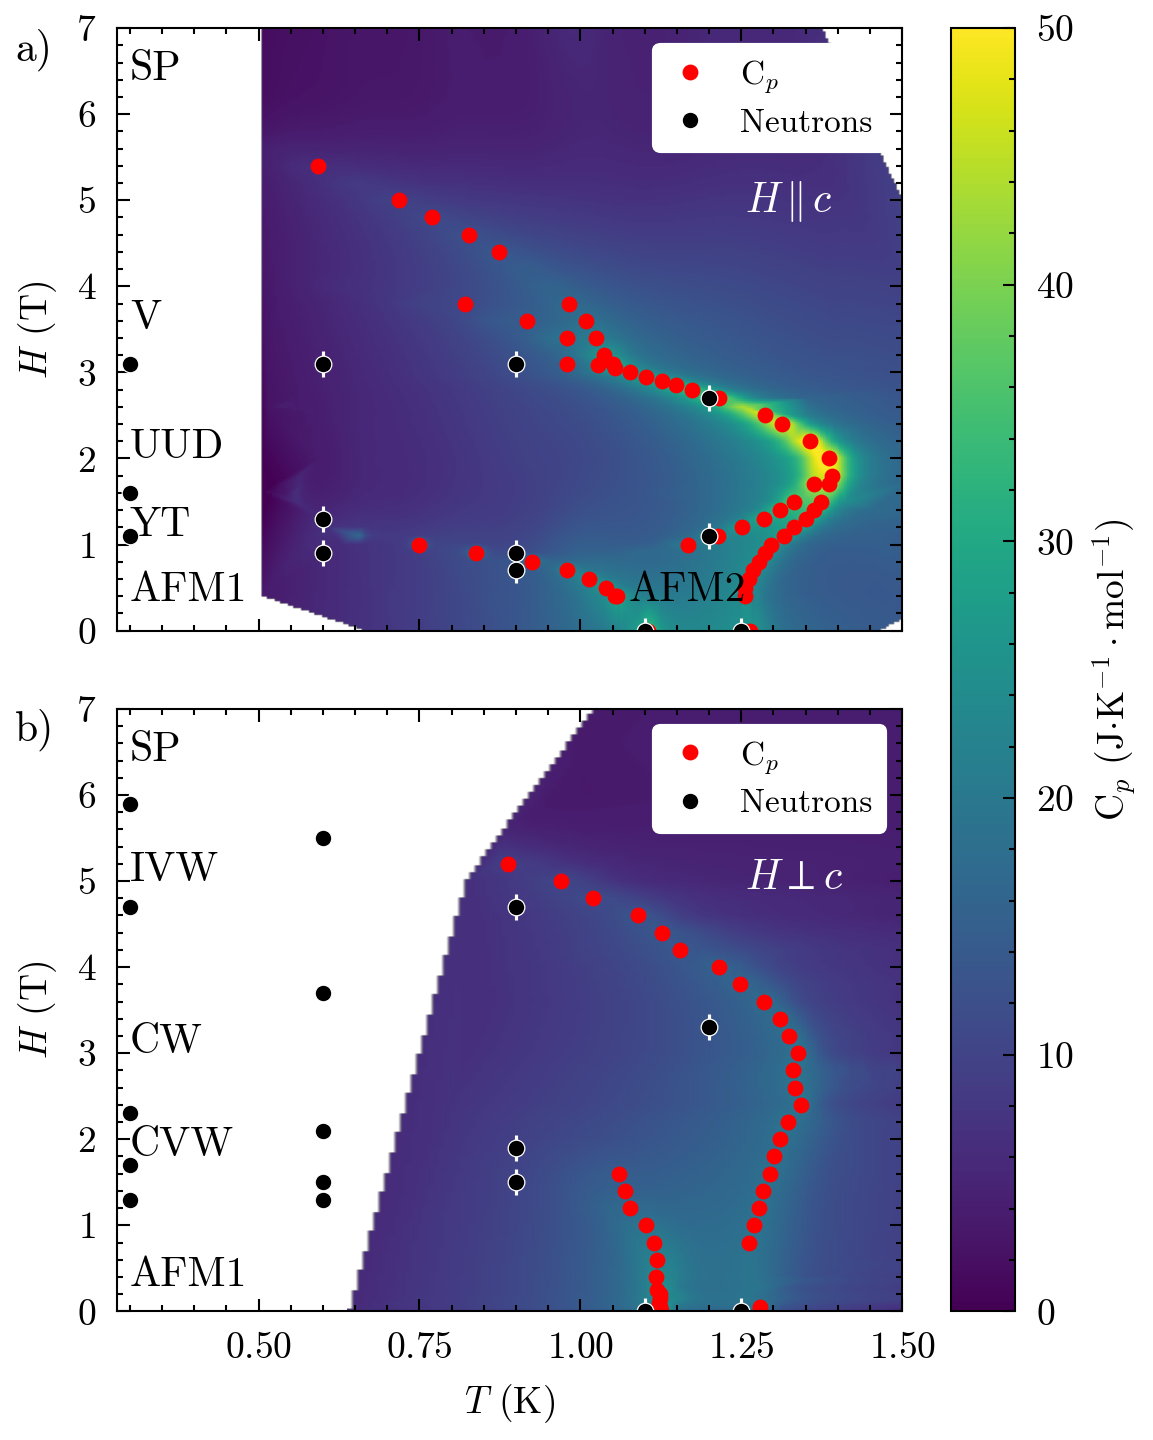

In [12]:
plt.rcParams['font.size'] = 10

# ------------------------------------------------------------------
# 2) Build a two-row figure, share x-axis
# ------------------------------------------------------------------
fig, axes = plt.subplots(
    2, 1, figsize=(4, 5), constrained_layout=True, sharex=True
)

### Along c axis
for ax, fielddir in zip(axes, ["c", "ab"]):
    #df = pd.read_csv(f"rawhc/NBMPO_along_{fielddir}.txt", names=["T","B_Oe","B","Cp"], sep=",", header=(1 if fielddir == "c" else 2), dtype=np.float64)
    df = hc_map[fielddir]
    x = df['T'].values
    y = df['B'].values
    z = df['Cp'].values
   
    # 3. Create a regular 2D grid to interpolate onto
    xi = np.linspace(x.min(), x.max(), 300)
    yi = np.linspace(y.min(), y.max(), 300)
    X, Y = np.meshgrid(xi, yi)

    # 4. Interpolate z values onto the grid
    Z = griddata((x, y), z, (X, Y), method='linear')  # or 'linear'/'nearest'

    # 5. Plot the result
    im = ax.imshow(Z, extent=(x.min(), x.max(), y.min(), y.max()),
                    origin='lower', cmap='viridis', aspect='auto', vmin=hc_scans[fielddir]["boundary"][0], vmax=hc_scans[fielddir]["boundary"][1])
    if fielddir == "ab":
        ax.set_xlabel('$T$ (K)')
    ax.set_xlim(0.28, 1.5)
    ax.set_ylim(0, 7)
    ax.set_ylabel('$H$ (T)')
    pattern = re.compile(r'([^,]*),([^,]*),([^,]*)')

    ax.plot(hc_points[fielddir]["T"], hc_points[fielddir]["B"], "ro", 
            label = r"C$_p$",
            markersize=2.8,)


    ax.errorbar(dfb[(dfb["dir"] == fielddir)]["T(K)"], dfb[(dfb["dir"] == fielddir)]["H(T)"],
                yerr=0.15,
                fmt = "bo", 
                label = "Neutrons",
                markersize=4,
                markerfacecolor="black",  
                markeredgecolor="white",  
                markeredgewidth=0.3,
                ecolor = "white")  
    ax.legend()


    if fielddir == "c":
        bdir = "\\,\\|\\,"
        letter = "a"
        ax.text(0.3, 0.35, "AFM1")
        ax.text(0.3, 1.1, "YT")
        ax.text(1.075, 0.35, "AFM2", color='black')
        ax.text(0.3, 2, "UUD")
        ax.text(0.3, 3.5, "V")
        ax.text(0.3, 6.4, "SP")
    else:
        bdir = "\\perp"
        letter = "b"
        ax.text(0.3, 0.3, "AFM1")
        ax.text(0.3, 1.8, "CVW")
        ax.text(0.3, 3, "CW")
        ax.text(0.3, 5.0, "IVW")
        ax.text(0.3, 6.4, "SP")
        #ax.text(1.13, 0.3, "AFM2", color='black', size=7)
    ax.text(
        0.8, 0.75, f"$H {bdir} c$",
        transform=ax.transAxes,
        fontsize="medium",
        fontweight="bold", color="white",
        va="top", ha="left"
    )
    ax.text(
        -0.13, 1, f"{letter})",
        transform=ax.transAxes,
        fontsize="medium",
        fontweight="bold", color="black",
        va="top", ha="left"
    )

fig.tight_layout()
# 3) One shared colorbar on the right
cbar = fig.colorbar(
    im, ax=axes.ravel().tolist(),
    location="right", label=r"C$_{p}$ (J$\cdot$K$^{-1}\cdot$mol$^{-1}$)",
    shrink=1.0
)
plt.savefig("fig4_nolines.pdf")
plt.show()


## Susceptibility

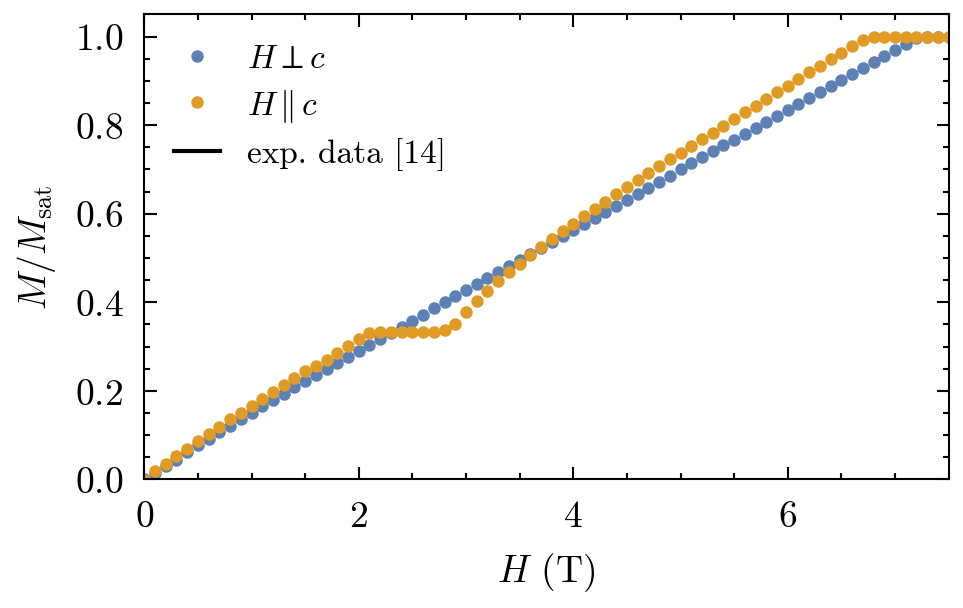

In [13]:
fig, ax = plt.subplots()
for field, dir in [("a", "Sx"), ("c", "Sz")]:
    if field == "c":
        bdir = "\\,\\|\\,"
    else:
        bdir = "\\perp"
    df = pd.read_csv(f"rawsim/MvsH_h{field}_kc0.035_J2Ja_0.0013_0.002_Jnn0.11.dat", 
                     sep='\\s+', comment='#',
                    names=['H', 'Sx', 'Sy', 'Sz'])

    # Create the scatter plot (ha vs Sx)
    
    ax.plot(df['H'], df[dir],"o", 
               markersize=2,label=f"$H{bdir} c$")
    ax.legend()

    ax.set_xlabel('$H$ (T)')
    ax.set_ylabel('$M/M_{\\mathrm{sat}}$')
    ax.set_xlim(0,7.5)
    ax.set_ylim(0,1.05)

exp_proxy = Line2D([], [], color="black", linewidth=1, label="Experiment [14]")

# vyzvedneme existující handly & popisky a přidáme proxy
handles, labels = ax.get_legend_handles_labels()
handles.append(exp_proxy)
labels.append("exp. data [14]")

ax.legend(handles, labels,  loc="best") 
plt.savefig("fig6_nolines.pdf")
plt.show()

## Specific heat from the model

In [14]:
# compare different calculated quantities
if False:
    phase_diagram_colormap_plotall('flaviano/output-Field8-0T-Bc_high_res_stat3', xlim=(0.05,1.5)); print('J2Ja_small k0.035 Jnn0.11 Bc')
    phase_diagram_colormap_plotall('flaviano/output-Field8-0T-Bc_high_res_stat2', xlim=(0.05,1.5)); print('J2Ja_small k0.035 Jnn0.11 Bc high definition')
    phase_diagram_colormap_plotall('flaviano/output-Field8-0T-Ba_high_res_stat3', xlim=(0.05,1.5)); print('J2Ja_small k0.035 Jnn0.11 Ba')
    phase_diagram_colormap_plotall('flaviano/output-Field8-0T-Ba_high_res_stat2', xlim=(0.05,1.5)); print('J2Ja_small k0.035 Jnn0.11 Ba high definition')

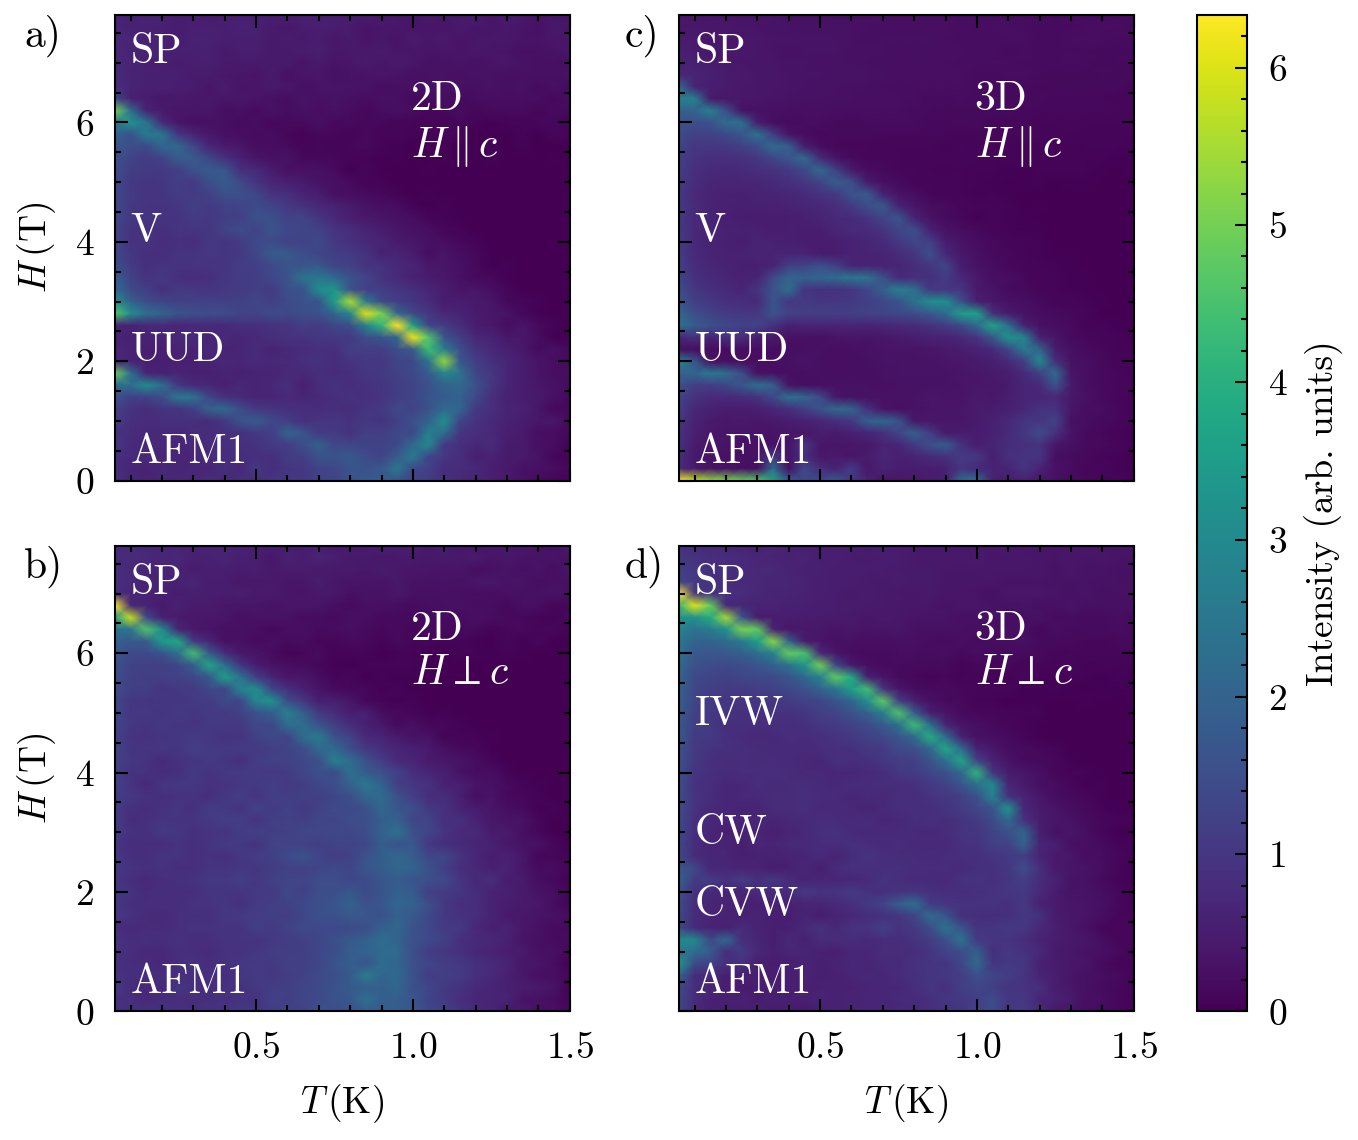

In [16]:
quantity_column_selection=5

fig, axes = plt.subplots(2, 2, figsize=(5, 4), sharex="all", sharey="all")
letters = "acbd"
#phase_diagram_colormap_plotall('vampire_tripleUC_3mat_2d_k0.35_Jnn0.11/output-Field8-0T-Bc_high_res_steps10000x10000', xlim=(0.05,1.5), fig_title='J2Ja_small k0.035 Jnn0.11 Bc 2D')
#phase_diagram_colormap_plotall('vampire_tripleUC_3mat_2d_k0.35_Jnn0.11/output-Field8-0T-Ba_high_res_steps10000x10000', xlim=(0.05,1.5), fig_title='J2Ja_small k0.035 Jnn0.11 Ba 2D')
for idx, (bdir, dim) in enumerate(product("ca", "23")):
    ax = axes[idx // 2, idx % 2]          # row = idx//2, column = idx%2
    if dim == "3":
        suffix = "stat3"
    else:
        suffix =  "steps10000x10000"
    folder = f"{dim}dmodel/output-Field8-0T-B{bdir}_high_res_{suffix}"
    list_of_output = column_to_plot(folder)
    d = plot_phase_diagram(folder, ax, fig, property='mean-specific-heat', title='',
                            list_of_output=list_of_output, 
                            quantity_column_selection=quantity_column_selection, xlim=(0.05,1.5), 
                            xlab="$T\\,(\\mathrm{K})$" if idx // 2 == 1 else "",
                            ylab="$H\\,(\\mathrm{T})$" if idx % 2 == 0 else "",
                            bar = False)
    ax.text(
        -0.2 + (0.08 if idx % 2 != 0 else 0), 1, f"{letters[idx]})",
        transform=ax.transAxes,
        fontsize="medium",
        fontweight="bold",
        va="top", ha="left"
    )
    dirsymbol = "\\perp" if bdir == "a" else "\\,\\|\\,"
    ax.text(
        0.65, 0.86, f"{dim}D\n$H {dirsymbol} c$",
        transform=ax.transAxes,
        fontsize="medium",
        fontweight="bold", color="white",
        va="top", ha="left"
    )
    match idx:
        case 0 | 1:
            ax.text(0.1, 0.3, "AFM1", color='white')
            ax.text(0.1, 2, "UUD", color='white')
            ax.text(0.1, 4, "V", color='white')
            ax.text(0.1, 7, "SP", color='white')
        case 2:
            ax.text(0.1, 0.3, "AFM1", color='white')
            ax.text(0.1, 7, "SP", color='white')
        case 3:
            ax.text(0.1, 0.3, "AFM1", color='white')
            ax.text(0.1, 1.6, "CVW", color='white')
            ax.text(0.1, 2.8, "CW", color='white')
            ax.text(0.1, 4.8, "IVW", color='white')
            ax.text(0.1, 7, "SP", color='white')
plt.tight_layout()
cbar = fig.colorbar(
    d, ax=axes.ravel().tolist(),
    location="right", label=r"Intensity (arb. units)",
    shrink=1.0
)
plt.savefig("fig7.pdf")
plt.show()


## Showing magnetic structures

In [17]:
def _load_png(ax, path: str, roi):
    ax.axis("off")
    
    arr = np.array(Image.open(folder + path))
    x, y, w, h = roi  # (x, y, w, h)

    ax.imshow(arr[y:y + h, x:x + w], interpolation="none")
    return 

def doCompass(ax, shifts, size = 0.5):
    
    vec_x = np.array([size, 0, 0])
    vec_y = np.array([size*np.cos(np.deg2rad(120)), size*np.sin(np.deg2rad(120)), 0])
    vec_z = np.cross(vec_x, vec_y); vec_z /= np.linalg.norm(vec_z)/size
    vecs, colors = [vec_x, vec_y, vec_z], ['r', 'g', 'b']
    views = ['x', 'y', 'z']
    
    plane_map = {
        'x': lambda v: (v[1], v[2]),  
        'y': lambda v: (v[0], v[2]),  
        'z': lambda v: (v[0], v[1])   
    }
    for view, sh in zip(views, shifts):
        for v, c in zip(vecs, colors):
            u, w = plane_map[view](v)
            if math.hypot(u, w) > 0:
                ax.arrow(*sh, u, w, color=c,
                        head_width=0.08, length_includes_head=True, 
                        lw=2, clip_on=False, zorder=10)
            else:
                ax.add_patch(Circle(sh, 0.05, color=c, clip_on=False, zorder=20))

def doTextAx(fig, gs, txt, shifts):
    ax_a = fig.add_subplot(gs[0, 0])
    ax_a.set_facecolor('black')
    if shifts is not None:
        doCompass(ax_a, shifts)
    ax_a.set_aspect('equal')
    ax_a.set_xlim(-1.1, 1.1); ax_a.set_ylim(-1.1, 1.1)
    ax_a.axis('off')
    
    ax_a.text(
        -1.,
        1.05, 
        txt,
        ha="left",
        va="top",
        linespacing=1.3,
        color="white"
    )

def doLines(fig, lenx):       
    # hline
    fig.lines.append(Line2D([0.02, 0.98], [0.50, 0.50],
                                transform=fig.transFigure,
                                color="white", linewidth=1))
    # vlines
    for x in (0.01+ i * 0.99 / lenx for i in range(1, lenx)):
        fig.lines.append(Line2D([x, x], [0.03, 0.97],
                                    transform=fig.transFigure,
                                    color="white", linewidth=1))

folder = "3dmodel/structures/"        
dpi = 300
width_ratios = (12, 15)
height_ratios = (1, 3)
field_dir = ["c", "ab"]

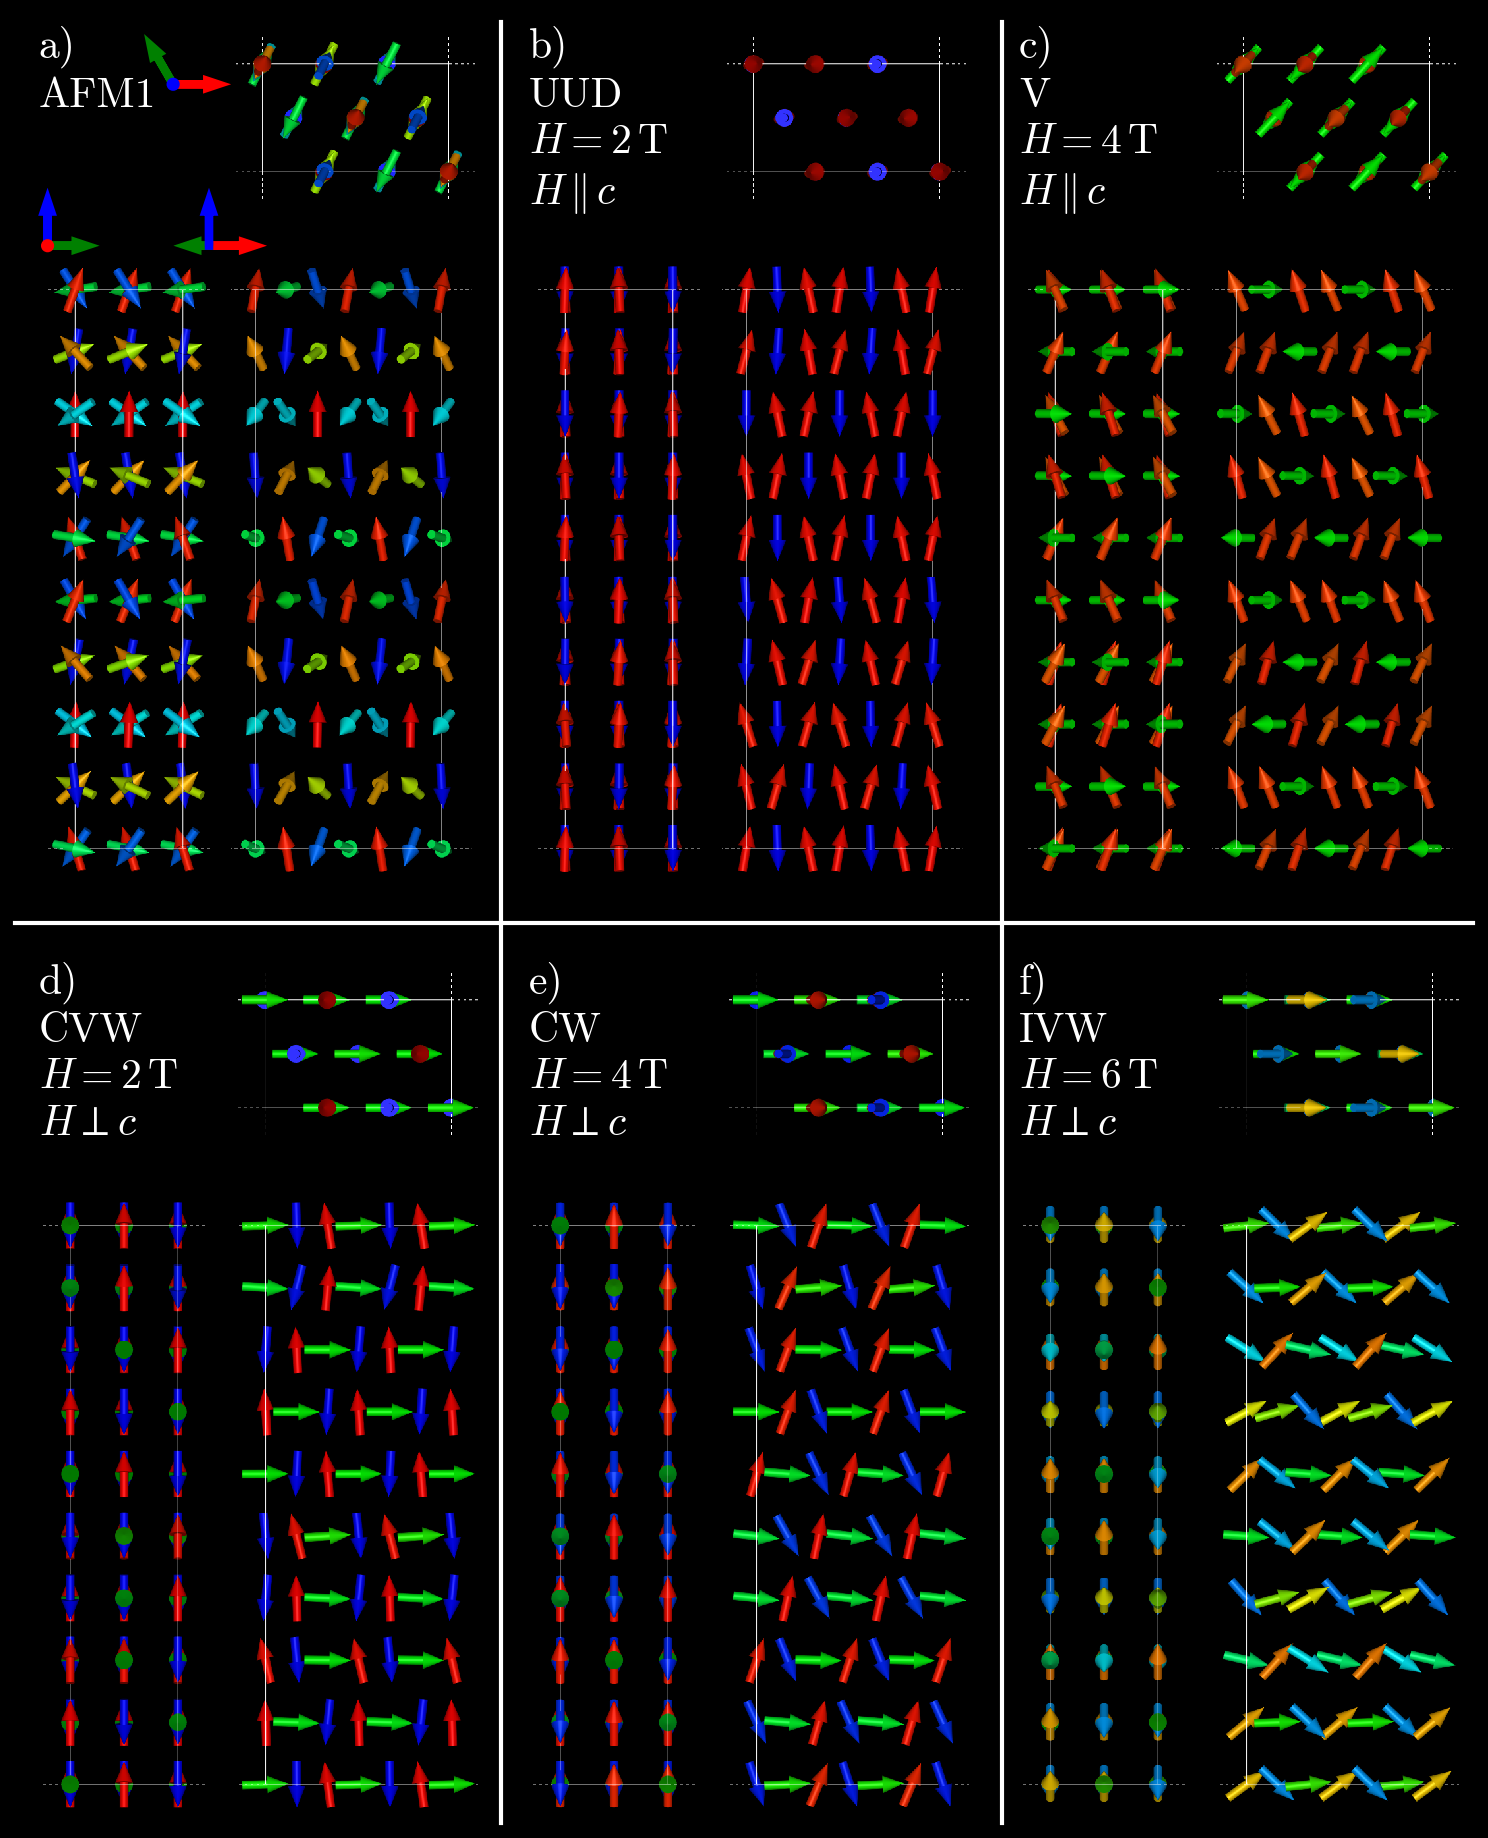

In [18]:
field_choices = [
    [1, 3, 5], #, 8],
    [3, 5, 7]  #, 8]
]
phase_naming = [
    ["AFM1", "UUD", "V"],#, "SP"],
    ["CVW", "CW", "IVW"],#, "SP"]
]

letters = [f"{ch})" for ch in ascii_lowercase[:8]]
lenx = 3
leny = 2
divider = 4

# Figure and GridSpec
fig = plt.figure(figsize=(6.75/divider*lenx, 12.77/divider*leny), dpi=dpi)
outer = fig.add_gridspec(leny, lenx)

for nx, ny in product(range(leny), range(lenx)):
    gs = outer[nx, ny].subgridspec(
        2, 2,
        width_ratios=width_ratios,
        height_ratios=height_ratios,
        wspace=0.02, hspace=0.02,
    )
    
    # Text and arrows
    bdir = "\\,\\|\\," if field_dir[nx] == "c" else "\\perp"
    show_field = f"\n$H={field_choices[nx][ny]-1}\\,\\mathrm{{T}}$\n$H{bdir} c$"
    shifts = None
    if (nx == ny == 0):
        shifts = [(-0.9,-1.4),(0.9,-1.4),(0.5,0.4)]
        show_field = ""
    txt = f"{letters.pop(0)}\n{phase_naming[nx][ny]}{show_field}"
    doTextAx(fig, gs, txt, shifts)
    

    filename = f"{field_dir[nx]}-{field_choices[nx][ny]}-Na2BaMnP2O8-view"
    # view along c
    ax_b = fig.add_subplot(gs[0, 1])
    img_b_arr = _load_png(ax_b, f"{filename}Z.png", (71,321,375,320))

    # view along a
    ax_c = fig.add_subplot(gs[1, 0])
    img_c_arr = _load_png(ax_c, f"{filename}X.png", (110,0,300,957))

    # view along a*
    ax_d = fig.add_subplot(gs[1, 1])
    img_d_arr = _load_png(ax_d, f"{filename}Y.png", (129,0,375,957))

doLines(fig, lenx)
    

plt.tight_layout()
fig.patch.set_facecolor("black") 
plt.savefig("fig8.pdf")
plt.show()



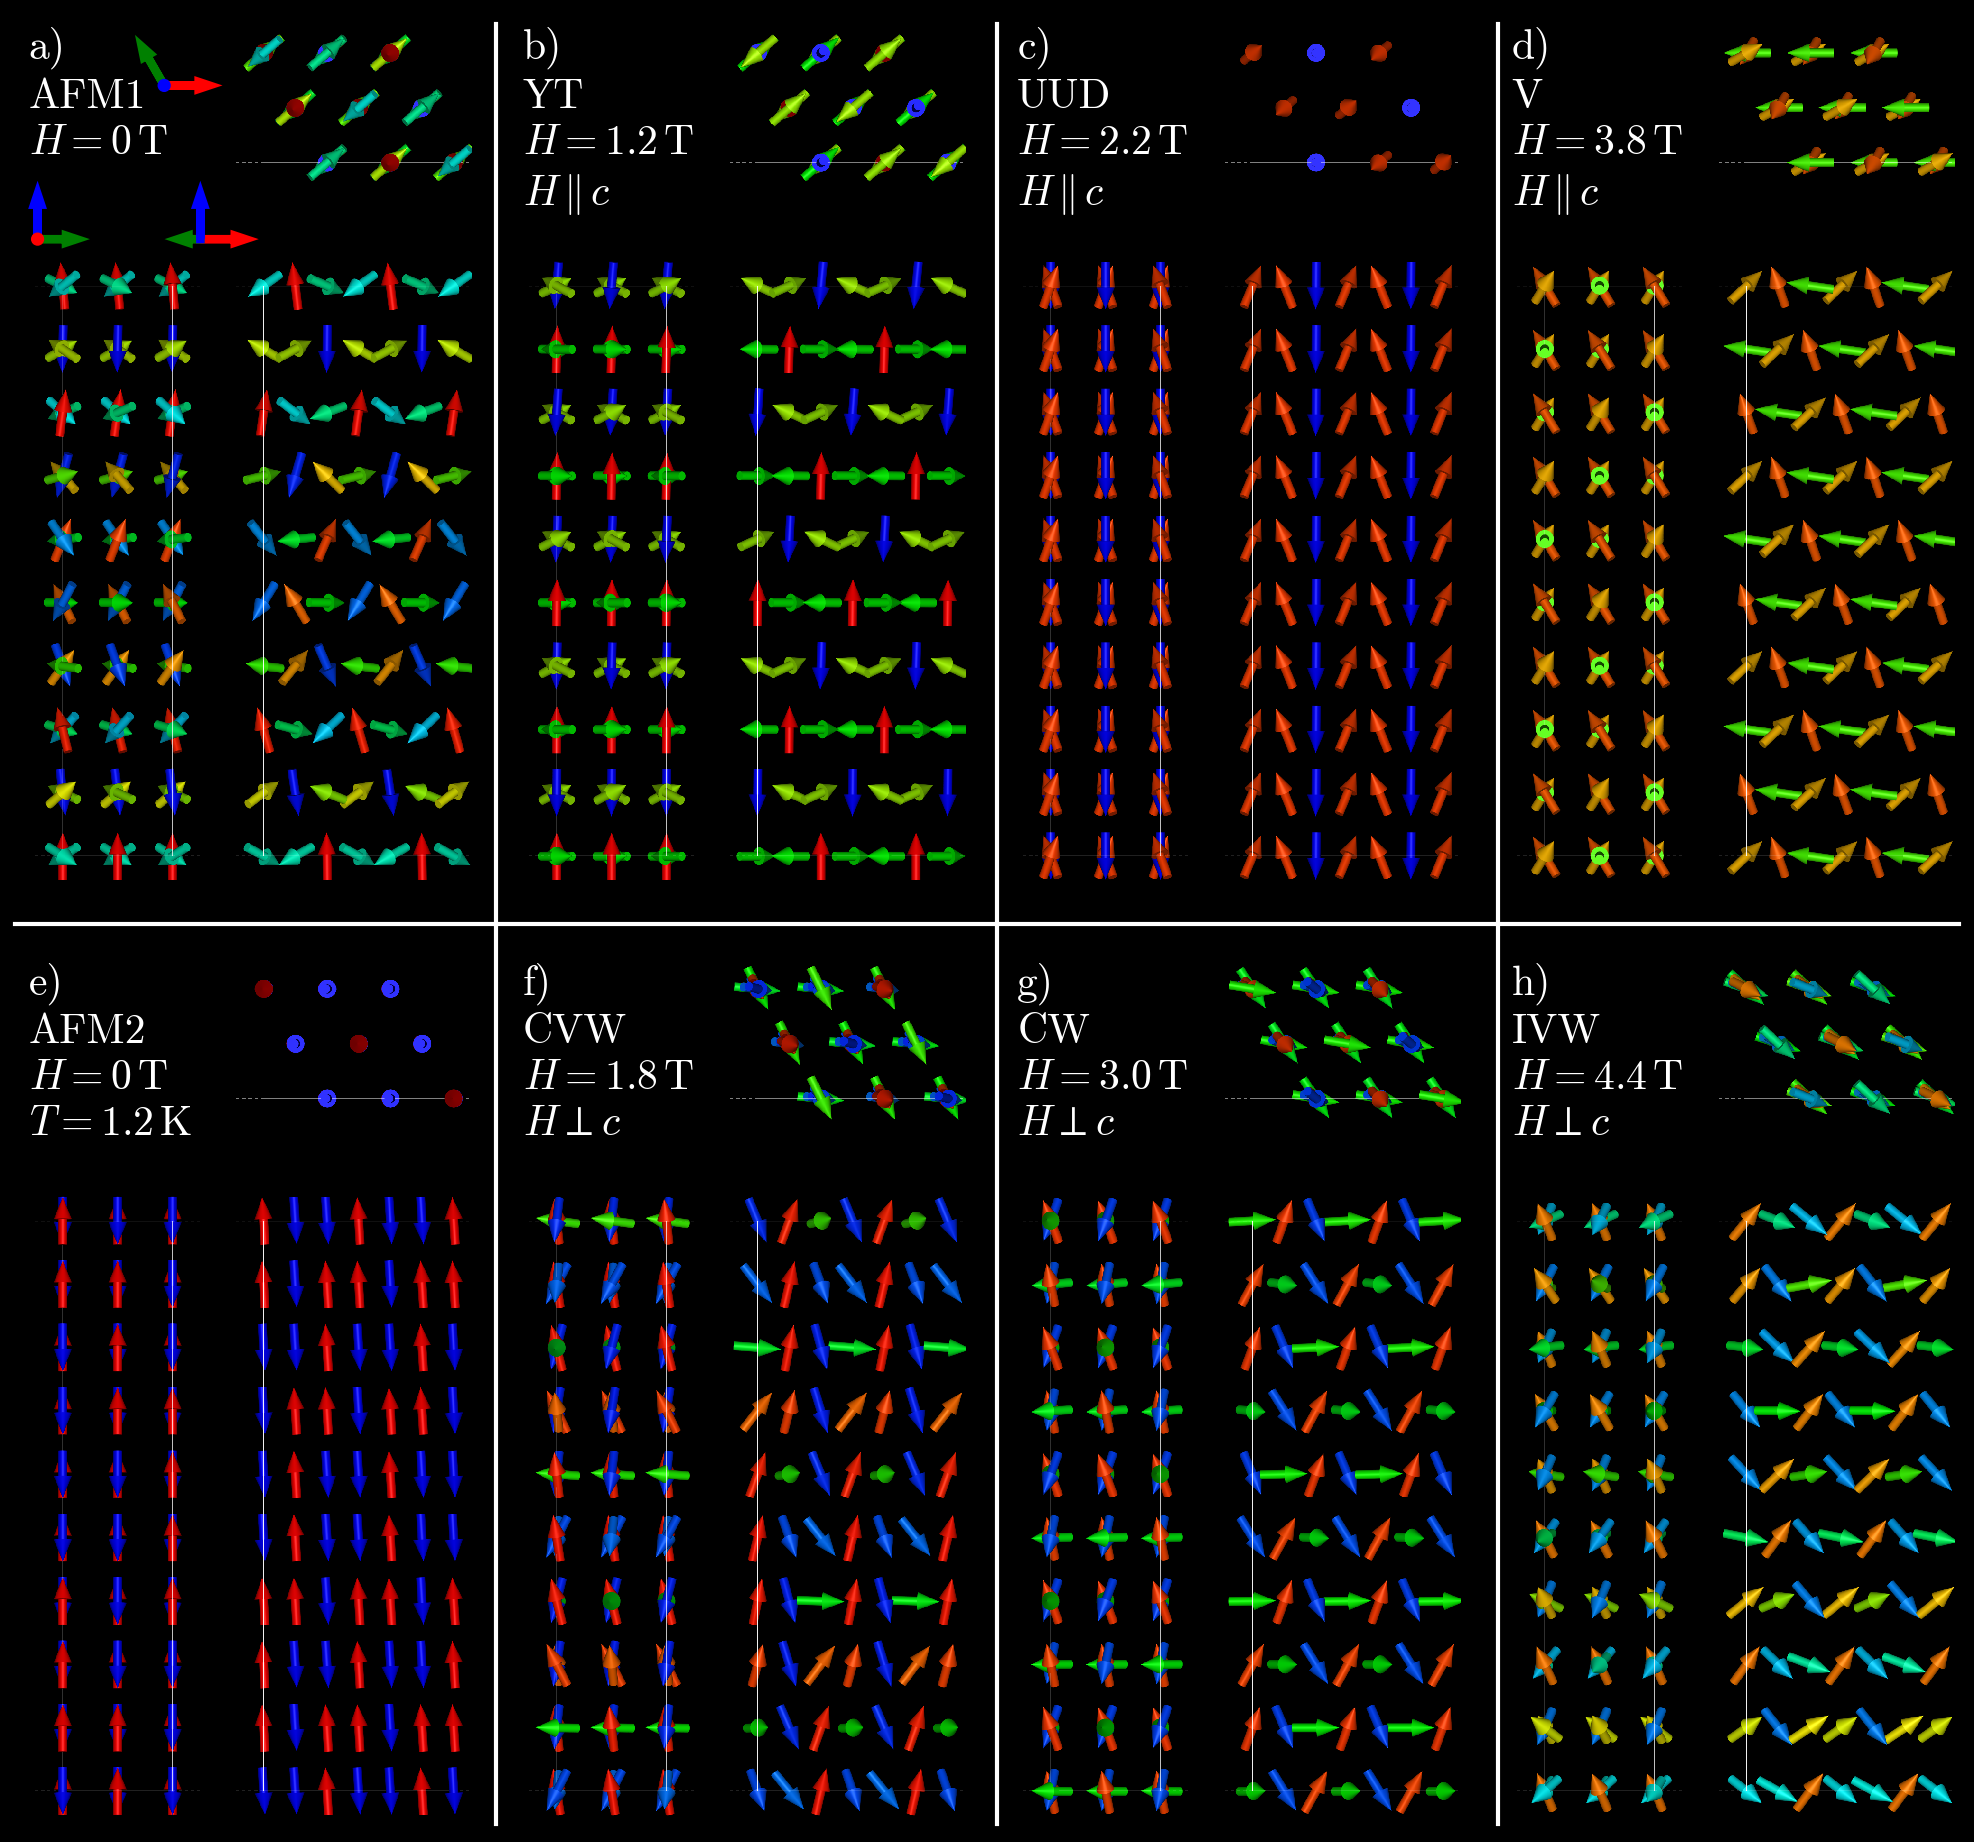

In [19]:
folder = "3dmodel/exp-structures/"
field_choices = [
    [0, 1.2, 2.2, 3.8], 
    [0, 1.8, 3, 4.4]  
]
phase_naming = [
    ["AFM1", "YT", "UUD", "V"],#, "SP"],
    ["AFM2", "CVW", "CW", "IVW"],#, "SP"]
]

letters = [f"{ch})" for ch in ascii_lowercase[:8]]
lenx = 4
leny = 2
divider = 4


# Figure and GridSpec
fig = plt.figure(figsize=(6.75/divider*lenx, 12.77/divider*leny), dpi=dpi)
outer = fig.add_gridspec(leny, lenx)

for nx, ny in product(range(leny), range(lenx)):
    gs = outer[nx, ny].subgridspec(
        2,
        2,
        width_ratios=width_ratios,
        height_ratios=height_ratios,
        wspace=0.02,
        hspace=0.02,
    )
    
    # Text and arrows
    bdir = "\\,\\|\\," if field_dir[nx] == "c" else "\\perp"
    show_field = f"\n$H={field_choices[nx][ny]:.1f}\\,\\mathrm{{T}}$\n$H{bdir} c$"
    shifts = None
    if (nx == ny == 0):
        shifts = [(-0.9,-1.3),(0.9,-1.3),(0.5,0.4)]
        show_field = f"\n$H=0\\,\\mathrm{{T}}$"
    if (nx == 1 and ny == 0):
        show_field = f"\n$H=0\\,\\mathrm{{T}}$\n$T=1.2\\,\\mathrm{{K}}$"
    txt = f"{letters.pop(0)}\n{phase_naming[nx][ny]}{show_field}"
    doTextAx(fig, gs, txt, shifts)

    filename = f"{(nx * 4) + (ny + 1)}-Na2BaMnP2O8-view"
    # view along c
    ax_b = fig.add_subplot(gs[0, 1])
    img_b_arr = _load_png(ax_b, f"{filename}Z.png", (346,412,int(525/401*538),int(451/401*538)))

    # view along a
    ax_c = fig.add_subplot(gs[1, 0])
    img_c_arr = _load_png(ax_c, f"{filename}X.png", (728,0,420,1354))

    # view along a*
    ax_d = fig.add_subplot(gs[1, 1])
    img_d_arr = _load_png(ax_d, f"{filename}Y.png", (648,0,525,1354))


doLines(fig, lenx)

plt.tight_layout()
fig.patch.set_facecolor("black") 
plt.savefig("fig5.pdf")
plt.show()


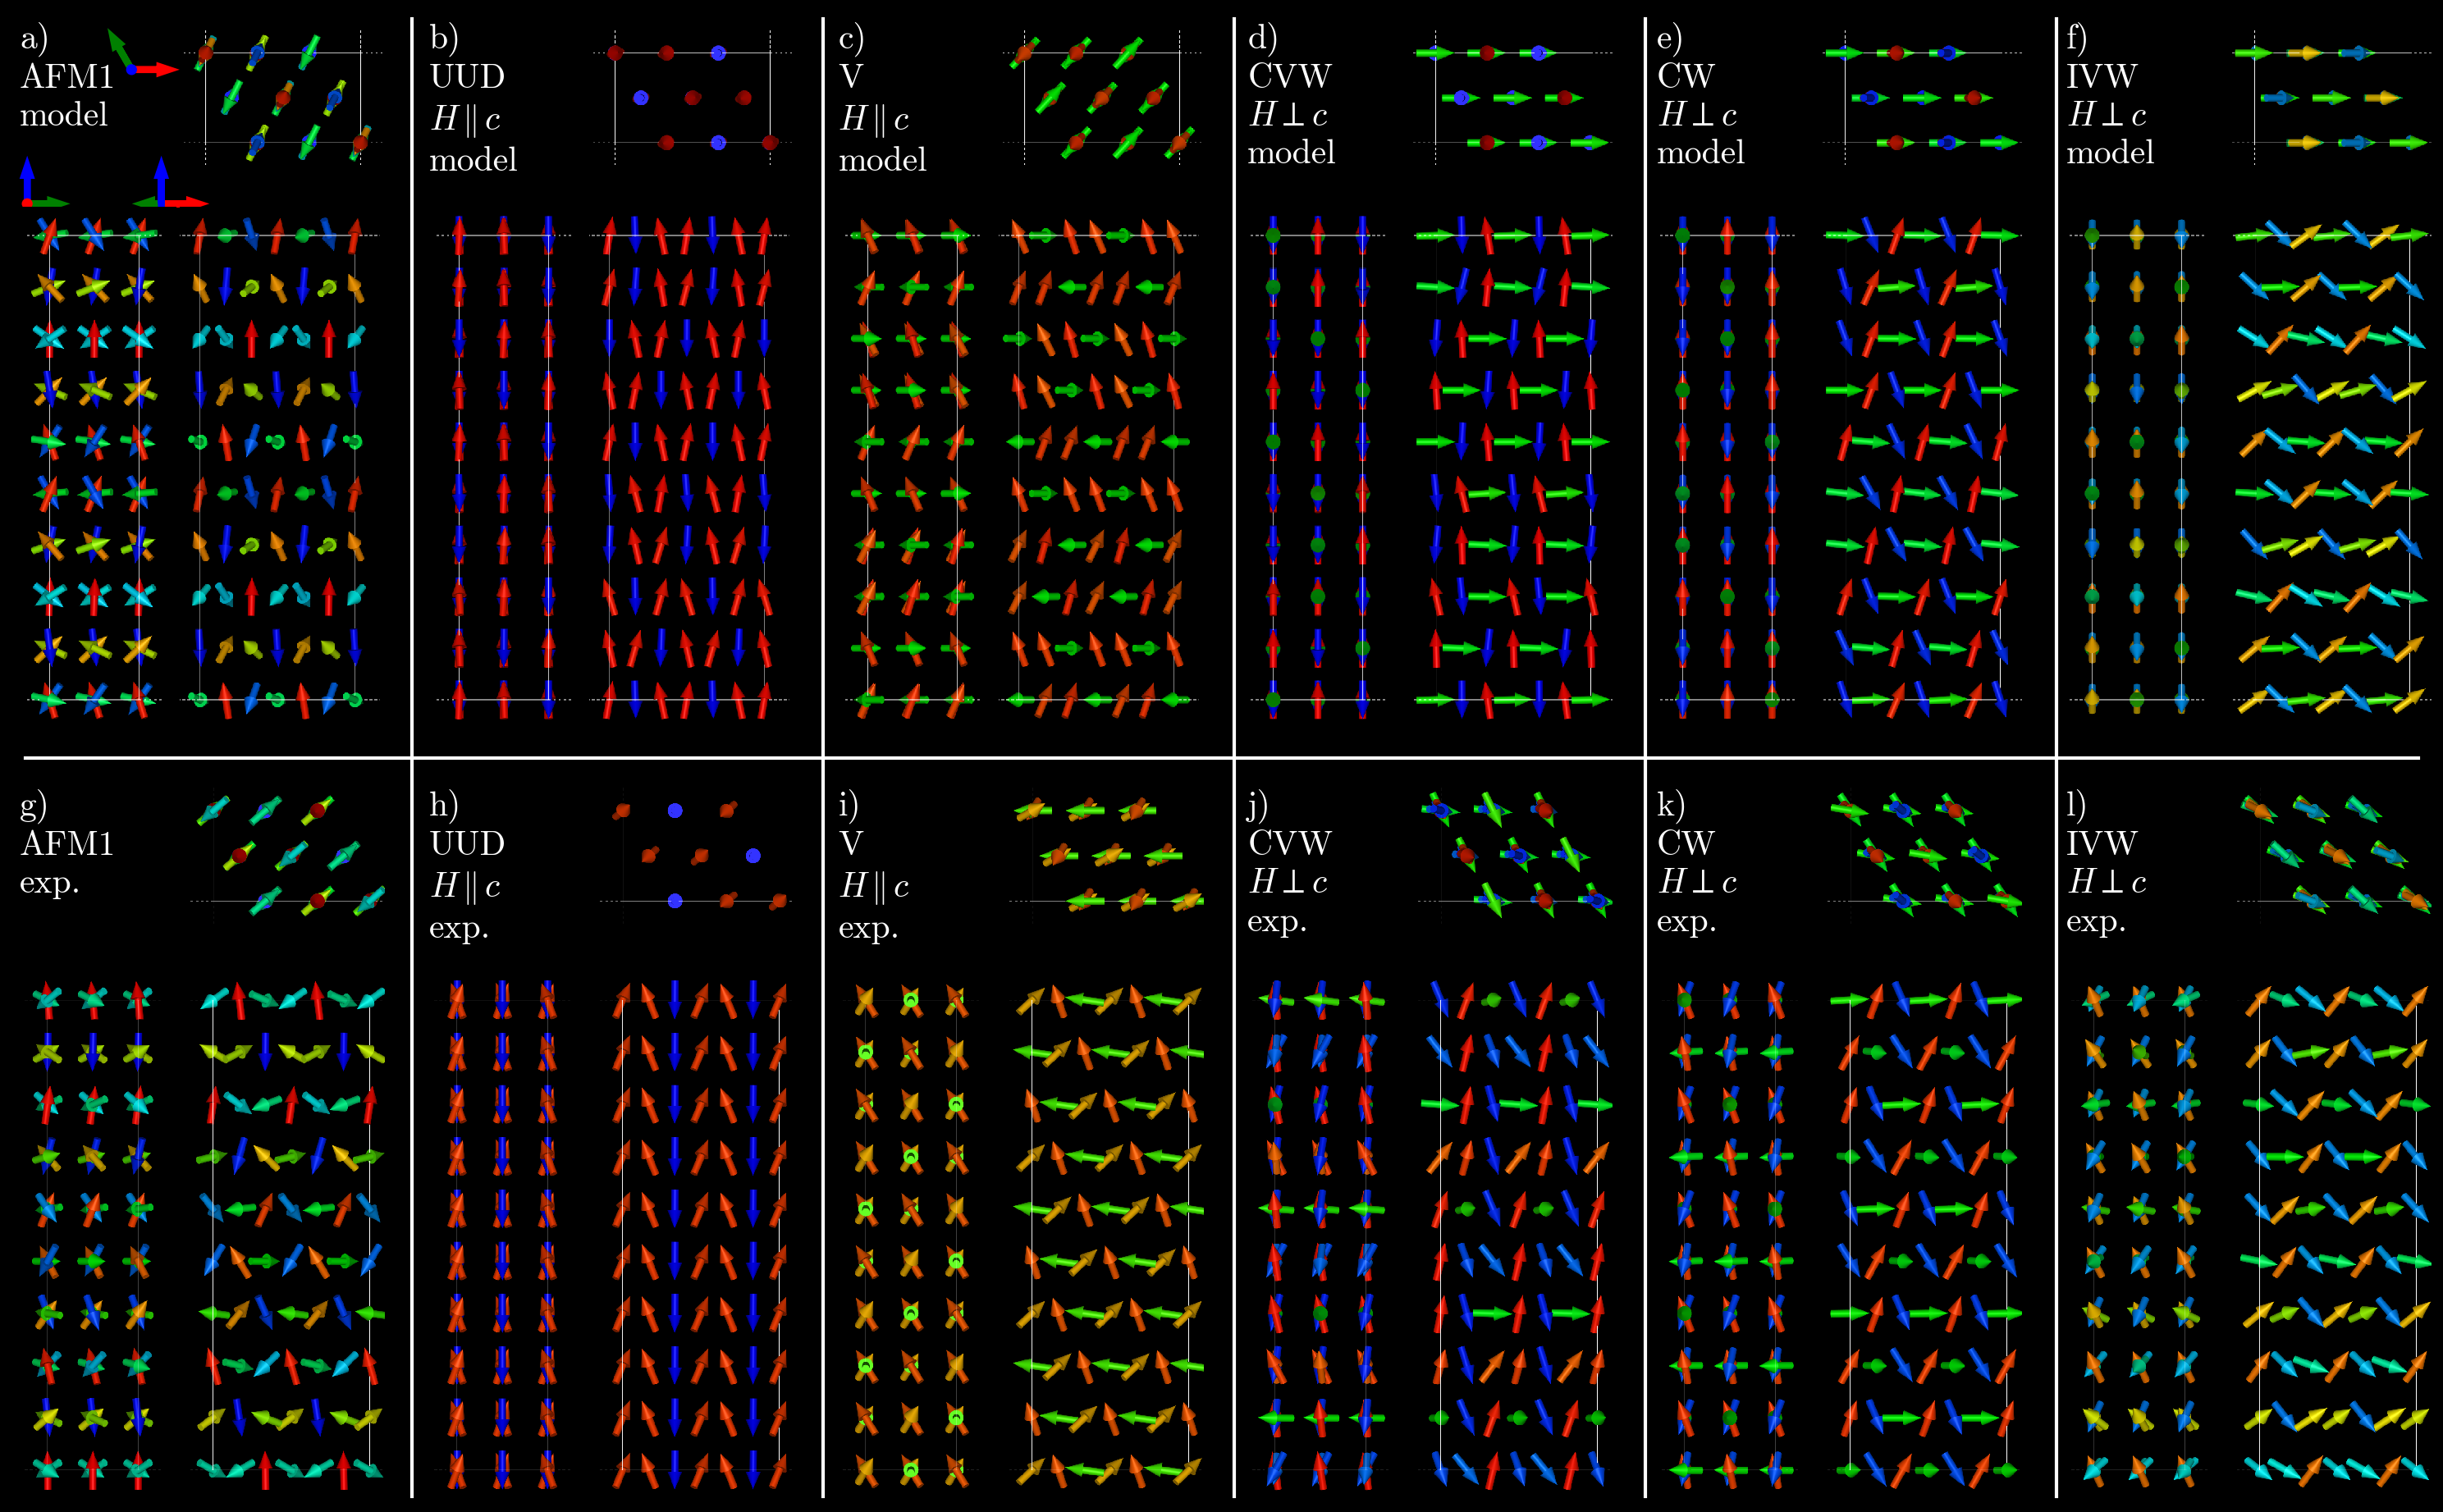

In [20]:
# Model - Experiment  comparison
folder = "3dmodel/"
field_choices = [
    [1, 3, 5, 3, 5, 7],
    [0, 2.2, 3.8, 1.8, 3, 4.4]  
]

phase_naming = [
    ["AFM1", "UUD", "V", "CVW", "CW", "IVW"],
    ["AFM1", "UUD", "V", "CVW", "CW", "IVW"],
]
exp_numbers = [1, 3, 4, 6, 7, 8]

letters = [f"{ch})" for ch in ascii_lowercase[:12]]
lenx = 6
leny = 2
divider = 4

# Figure and GridSpec
fig = plt.figure(figsize=(6.75/divider*lenx, 12.77/divider*leny), dpi=dpi)
outer = fig.add_gridspec(leny, lenx)

for nx, ny in product(range(leny), range(lenx)):
    gs = outer[nx, ny].subgridspec(
        2, 2,
        width_ratios=width_ratios,
        height_ratios=height_ratios,
        wspace=0.02, hspace=0.02,
    )
    
    # Text and arrows
    bdir = "\\,\\|\\," if field_dir[ny // 3] == "c" else "\\perp"
    show_field = f"\n$H{bdir} c$"
    shifts = None
    if (nx == ny == 0):
        shifts = [(-0.9,-1.4),(0.9,-1.4),(0.5,0.4)]
    if (ny == 0):
        show_field = ""
    txt = f"{letters.pop(0)}\n{phase_naming[nx][ny]}{show_field}\n{'model' if nx == 0 else 'exp.'}"
    doTextAx(fig, gs, txt, shifts)
    
    if nx == 0:
        filename = f"structures/{field_dir[ny // 3]}-{field_choices[nx][ny]}-Na2BaMnP2O8-view"
        # view along c
        ax_b = fig.add_subplot(gs[0, 1])
        img_b_arr = _load_png(ax_b, f"{filename}Z.png", (71,321,375,320))

        # view along a
        ax_c = fig.add_subplot(gs[1, 0])
        img_c_arr = _load_png(ax_c, f"{filename}X.png", (110,0,300,957))

        # view along a*
        ax_d = fig.add_subplot(gs[1, 1])
        img_d_arr = _load_png(ax_d, f"{filename}Y.png", (129,0,375,957))
    else:
        filename = f"exp-structures/{exp_numbers[ny]}-Na2BaMnP2O8-view"
        # view along c
        ax_b = fig.add_subplot(gs[0, 1])
        img_b_arr = _load_png(ax_b, f"{filename}Z.png", (346,412,int(525/401*538),int(451/401*538)))

        # view along a
        ax_c = fig.add_subplot(gs[1, 0])
        img_c_arr = _load_png(ax_c, f"{filename}X.png", (728,0,420,1354))

        # view along a*
        ax_d = fig.add_subplot(gs[1, 1])
        img_d_arr = _load_png(ax_d, f"{filename}Y.png", (648,0,525,1354))
  

doLines(fig, lenx)
    

plt.tight_layout()
fig.patch.set_facecolor("black") 
plt.savefig("fig-s3.pdf")
plt.show()
